# Importation

In [1]:
from sklearn.metrics import make_scorer,SCORERS,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression,SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

# Load dataframe

In [2]:
data = pd.read_csv("predictions_vinci")
data.head()

,Unnamed: 0,yesterday,prediction,conf_low,conf_high,true,conf_std,Date,perf_pred,perf_true,perf_low,perf_high,garch_pred,vol_variation,prediction_cnn
0,0,101.311661,100.229275,98.853678,101.604872,100.998656,0.701848,2016-09-29,-0.010684,-0.003090,-0.024262,0.002894,21.300782,-0.004677,0.000385
1,1,100.998656,102.686427,101.292483,104.080370,101.535259,0.711209,2016-09-30,0.016711,0.005313,0.002909,0.030512,21.186977,-0.005343,0.000222
2,2,101.535259,101.803834,100.377070,103.230599,101.445808,0.727954,2016-10-03,0.002645,-0.000881,-0.011407,0.016697,21.075146,-0.005278,0.000415
3,3,101.445808,101.608547,100.183373,103.033721,101.997306,0.727143,2016-10-04,0.001604,0.005436,-0.012444,0.015653,21.142841,0.003212,0.000095
4,4,101.997306,101.715455,100.285934,103.144976,100.298096,0.729361,2016-10-05,-0.002763,-0.016659,-0.016779,0.011252,21.256323,0.005367,0.000280


In [3]:
data.shape

(1131, 15)

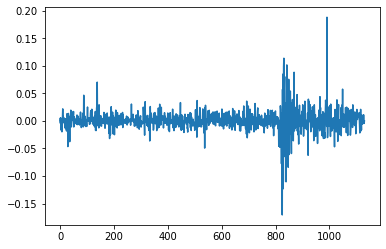

In [4]:
plt.plot(data.perf_true)

In [5]:
data = pd.concat([data.loc[:800],data.loc[1000:]],axis=0)

In [6]:
feature_to_remove = ["Unnamed: 0","yesterday","prediction","conf_low","conf_high","true","Date"]

In [7]:
data.head()

,Unnamed: 0,yesterday,prediction,conf_low,conf_high,true,conf_std,Date,perf_pred,perf_true,perf_low,perf_high,garch_pred,vol_variation,prediction_cnn
0,0,101.311661,100.229275,98.853678,101.604872,100.998656,0.701848,2016-09-29,-0.010684,-0.003090,-0.024262,0.002894,21.300782,-0.004677,0.000385
1,1,100.998656,102.686427,101.292483,104.080370,101.535259,0.711209,2016-09-30,0.016711,0.005313,0.002909,0.030512,21.186977,-0.005343,0.000222
2,2,101.535259,101.803834,100.377070,103.230599,101.445808,0.727954,2016-10-03,0.002645,-0.000881,-0.011407,0.016697,21.075146,-0.005278,0.000415
3,3,101.445808,101.608547,100.183373,103.033721,101.997306,0.727143,2016-10-04,0.001604,0.005436,-0.012444,0.015653,21.142841,0.003212,0.000095
4,4,101.997306,101.715455,100.285934,103.144976,100.298096,0.729361,2016-10-05,-0.002763,-0.016659,-0.016779,0.011252,21.256323,0.005367,0.000280


In [8]:
data = data.drop(columns=feature_to_remove)

In [9]:
X = data.copy().drop(columns="perf_true")
y= data["perf_true"]

In [10]:
mae_arima = mean_absolute_error(data.perf_true,data.perf_pred)
mae_arima

0.005573940268258703

In [11]:
#to confirme with Arno?
mae_cnn = mean_absolute_error(data.perf_true,data.prediction_cnn)
mae_cnn

0.008644149715386828

# GridSearch SVM

In [12]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [13]:

# Instanciate model
model_svm = Pipeline([("scale",StandardScaler()),("svm",SVR())])

# Hyperparameter search space
search_space = {
    'svm__kernel': ["linear", "poly", "rbf", "sigmoid"],
    'svm__C': stats.uniform(0.01, 1000),
    'svm__gamma': stats.loguniform(0.001,10),
    'svm__coef0': stats.uniform(-5,5),
}

# Instanciate Random Search
search_svm = RandomizedSearchCV(
    model_svm, search_space,
    n_jobs=-1, scoring='neg_mean_absolute_error', cv=5, n_iter=1, verbose=0)


search_svm.fit(X,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('svm',
                                              SVR(C=1.0, cache_size=200,
                                                  coef0=0.0, degree=3,
                                                  epsilon=0.1, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=1, n_jobs=-1,
                

In [14]:
search_svm.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVR(C=79.8705880429688, cache_size=200,
                     coef0=-2.390679775172929, degree=3, epsilon=0.1,
                     gamma=0.0027532067390641187, kernel='poly', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [15]:
search_svm.best_score_ 

-0.011983611057810067

# GridSearch KNN

In [16]:
model_knn = Pipeline([("scale",StandardScaler()),("knn",KNeighborsRegressor())])

param_grid_knn =  {'knn__n_neighbors': range(2,50)}
search_knn = GridSearchCV(model_knn, param_grid=param_grid_knn, 
                          cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_knn.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             iid='d

In [17]:
search_knn.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=37, p=2,
                                     weights='uniform'))],
         verbose=False)

In [18]:
search_knn.best_score_

-0.006001089766862984

# GridSearch Ridge

In [19]:
model_ridge = Pipeline([("scale",StandardScaler()),("ridge",Ridge())])
param_grid_ridge =  {'ridge__alpha': np.linspace(0.0001,2,num=1000)}
search_ridge = GridSearchCV(model_ridge, param_grid=param_grid_ridge, 
                              cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_ridge.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'ridge__alpha': array([1.0000...
       1.96196386e+00, 1.96396577e+00, 1.96596767e+00, 1.96796957e+00,
       1.96997147e+00, 1.97197337e+00, 

In [20]:
search_ridge.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=2.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [21]:
search_ridge.best_score_

-0.005708765485245554

# GridSearch Lasso

In [22]:
model_lasso = Pipeline([("scale",StandardScaler()),("lasso",Lasso())])
param_grid_lasso =  {'lasso__alpha': np.linspace(0.0001,2,num=1000)}
search_lasso = GridSearchCV(model_lasso, param_grid=param_grid_lasso, 
                              cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_lasso.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='depreca...
       1.96196386e+00, 1.963965

In [23]:
search_lasso.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.0001, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [24]:
search_lasso.best_score_

-0.005585453913986744

# GridSearch  SGD

In [25]:
model_sgd = Pipeline([("scale",StandardScaler()),("sgd",SGDRegressor())]) 
param_grid_sgd =  {'sgd__alpha': np.linspace(0.0001,2,num=100),
                  'sgd__penalty': ["l2", "l1", "elasticnet"],
                  "sgd__l1_ratio" :np.linspace(0,1,num=10) }
search_sgd = GridSearchCV(model_sgd, param_grid=param_grid_sgd, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_sgd.fit(X,y)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgd',
                                        SGDRegressor(alpha=0.0001,
                                                     average=False,
                                                     early_stopping=False,
                                                     epsilon=0.1, eta0=0.01,
                                                     fit_intercept=True,
                                                     l1_ratio=0.15,
                                                     learning_rate='invscaling',
                                                     loss='squared_loss',
                               

In [26]:
search_sgd.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.2222222222222222,
                              learning_rate='invscaling', loss='squared_loss',
                              max_iter=1000, n_iter_no_change=5, penalty='l1',
                              power_t=0.25, random_state=None, shuffle=True,
                              tol=0.001, validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

In [27]:
search_sgd.best_score_

-0.005551243668168099

# GridSearch Descision Tree

In [28]:
model_des_tree = Pipeline([("scale",StandardScaler()),("desTree",DecisionTreeRegressor())]) 
param_grid_des_tree =  {'desTree__max_depth': range(2,100),
                  "desTree__min_samples_leaf" :range(2,100) }
search_des_tree = GridSearchCV(model_des_tree, param_grid=param_grid_des_tree, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_des_tree.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9604 candidates, totalling 48020 fits


[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 15948 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 23068 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 31500 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 41212 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 48020 out of 48020 | elapsed:  5.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('desTree',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                    

In [29]:
search_des_tree.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('desTree',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=3, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=46, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

In [30]:
search_des_tree.best_score_

-0.005956539234083696

# GridSearch Random forest

In [31]:
model_rand_tree =  Pipeline([("scale",StandardScaler()),("forest",RandomForestRegressor(criterion="mae"))]) 
param_grid_rand_tree =  {"forest__n_estimators": [10,50, 100, 300, 500, 1000],
                         'forest__max_depth': np.linspace(5,500,10),
                          "forest__min_samples_leaf" :[5] }
search_rand_tree = GridSearchCV(model_rand_tree, param_grid=param_grid_rand_tree, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_rand_tree.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('forest',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mae',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                     

In [32]:
search_rand_tree.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('forest',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mae', max_depth=5.0,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=5, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [33]:
search_rand_tree.best_score_

-0.0058163234244031576

# GridSearch Gradient Boost

In [34]:
model_gboost = Pipeline([("scale",StandardScaler()),("gboost",GradientBoostingRegressor(criterion="mae"))]) 
param_grid_gboost =  {'gboost__n_estimators': [10,50, 100, 300, 500, 1000],
                      "gboost__learning_rate": [0.0001,0.001,0.003,0.01,0.03,0.1,0.3,1]}
search_gboost = GridSearchCV(model_gboost, param_grid=param_grid_gboost, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_gboost.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 28.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('gboost',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='mae',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                    

In [35]:
search_gboost.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gboost',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='mae', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=50,
                                           n_iter_no_change=None,
                                 

In [36]:
search_gboost.best_score_

-0.006103209933999428

# GridSearch Ada Boost

In [37]:
model_aboost = Pipeline([("scale",StandardScaler()),("aboost",AdaBoostRegressor())])
param_aboost =  {'aboost__n_estimators': [10,50, 100, 300, 500, 1000],
                      "aboost__learning_rate": [0.0001,0.001,0.003,0.01,0.03,0.1,0.3,1],
                      "aboost__loss":['linear', 'square', 'exponential']}
search_aboost = GridSearchCV(model_aboost, param_grid=param_aboost, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_aboost.fit(X,y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('aboost',
                                        AdaBoostRegressor(base_estimator=None,
                                                          learning_rate=1.0,
                                                          loss='linear',
                                                          n_estimators=50,
                                                          random_state=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'aboost__learning_rate': [0.0001, 0.001, 0.003, 0.01,
                                                   0.03, 0

In [38]:
search_aboost.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('aboost',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.0001,
                                   loss='linear', n_estimators=10,
                                   random_state=None))],
         verbose=False)

In [39]:
search_aboost.best_score_

-0.0058725018508027456

# Stacking 

In [40]:
gboost = search_gboost.best_estimator_
ridge = search_ridge.best_estimator_
lasso = search_lasso.best_estimator_
svm = search_svm.best_estimator_
adaboost = search_aboost.best_estimator_
forest = search_rand_tree.best_estimator_
desTree = search_des_tree.best_estimator_
sgd = search_sgd.best_estimator_
knn = search_knn.best_estimator_




model_stacking = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge),("svm", svm),
                 ("lasso", lasso),("forest", forest),("desTree", desTree),("sgd", sgd),("knn", knn)],
    weights = [1,1,1,1,1,1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

score = cross_val_score(model_stacking, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print(score.std())
score.mean()

0.0007498990864395879


-0.005810205335281424

# Neural Network

In [41]:
data2 = pd.read_csv("predictions_vinci")
data2 = data2.drop(columns=feature_to_remove)
data2.head()

,conf_std,perf_pred,perf_true,perf_low,perf_high,garch_pred,vol_variation,prediction_cnn
0,0.701848,-0.010684,-0.003090,-0.024262,0.002894,21.300782,-0.004677,0.000385
1,0.711209,0.016711,0.005313,0.002909,0.030512,21.186977,-0.005343,0.000222
2,0.727954,0.002645,-0.000881,-0.011407,0.016697,21.075146,-0.005278,0.000415
3,0.727143,0.001604,0.005436,-0.012444,0.015653,21.142841,0.003212,0.000095
4,0.729361,-0.002763,-0.016659,-0.016779,0.011252,21.256323,0.005367,0.000280


In [42]:
X2 = data2.copy().drop(columns="perf_true")
y2= data2["perf_true"]

In [43]:
X2[800:]

,conf_std,perf_pred,perf_low,perf_high,garch_pred,vol_variation,prediction_cnn
800,0.953856,0.000527,-0.010611,0.011665,80.583939,-0.122408,0.000095
801,1.048799,0.007429,-0.004600,0.019457,91.793703,0.139107,0.000095
802,1.080792,0.004702,-0.007759,0.017164,80.727591,-0.120554,0.000095
803,1.083552,0.010821,-0.001654,0.023296,85.173972,0.055079,0.000095
804,1.082054,0.003450,-0.008919,0.015818,77.207298,-0.093534,0.000095
...,...,...,...,...,...,...,...
1126,1.314958,-0.003736,-0.019600,0.012127,14.462025,0.015707,0.000223
1127,1.191138,0.004214,-0.010282,0.018711,13.084130,-0.068074,0.000427
1128,1.194974,0.003450,-0.010933,0.017832,13.287345,0.015531,0.000235
1129,1.187985,0.000363,-0.013949,0.014675,13.311260,0.001800,0.000345


In [44]:
es = EarlyStopping(patience=10, restore_best_weights=True)
normalizer = Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X2[:600]) # "Fit" it on the train set


model_nn = Sequential()
model_nn.add(normalizer)
model_nn.add(layers.Dense(100, input_dim=7, activation='tanh'))  
model_nn.add(layers.Dense(50, activation='tanh'))
model_nn.add(layers.Dense(20, activation='tanh'))
model_nn.add(layers.Dense(10, activation='tanh'))
model_nn.add(layers.Dense(20, activation='tanh'))
model_nn.add(layers.Dense(50, activation='tanh'))
model_nn.add(layers.Dense(100, activation='tanh'))
model_nn.add(layers.Dense(1, activation='linear')) 

# STEP 2: OPTIMIZATION METHODS
model_nn.compile(loss='mae', optimizer='adam')

# SETP 3: DATA AND FITTING METHODS
model_nn.fit(X2[:800], y2[:800], batch_size=32, epochs=500, callbacks=[es],verbose=2)
model_nn.evaluate(X2[800:],y2[800:])

Epoch 1/500
25/25 - 1s - loss: 0.0394
Epoch 2/500
25/25 - 0s - loss: 0.0104
Epoch 3/500
25/25 - 0s - loss: 0.0086
Epoch 4/500
25/25 - 0s - loss: 0.0069
Epoch 5/500
25/25 - 0s - loss: 0.0080
Epoch 6/500
25/25 - 0s - loss: 0.0074
Epoch 7/500
25/25 - 0s - loss: 0.0067
Epoch 8/500
25/25 - 0s - loss: 0.0059
Epoch 9/500
25/25 - 0s - loss: 0.0063
Epoch 10/500
25/25 - 0s - loss: 0.0063
Epoch 11/500
25/25 - 0s - loss: 0.0059
Epoch 12/500
25/25 - 0s - loss: 0.0061
Epoch 13/500
25/25 - 0s - loss: 0.0067
Epoch 14/500
25/25 - 0s - loss: 0.0060
Epoch 15/500
25/25 - 0s - loss: 0.0061
Epoch 16/500
25/25 - 0s - loss: 0.0058
Epoch 17/500
25/25 - 0s - loss: 0.0062
Epoch 18/500
25/25 - 0s - loss: 0.0060
Epoch 19/500
25/25 - 0s - loss: 0.0059
Epoch 20/500
25/25 - 0s - loss: 0.0059
Epoch 21/500
25/25 - 0s - loss: 0.0072
Epoch 22/500
25/25 - 0s - loss: 0.0065
Epoch 23/500
25/25 - 0s - loss: 0.0057
Epoch 24/500
25/25 - 0s - loss: 0.0055
Epoch 25/500
25/25 - 0s - loss: 0.0057
Epoch 26/500
25/25 - 0s - loss: 0.

0.015729164704680443

In [45]:
mae_arima2 = mean_absolute_error(data2.perf_true,data2.perf_pred)
mae_arima2

0.007416762485498858

In [46]:
mae_cnn2 = mean_absolute_error(data2.perf_true,data2.prediction_cnn)
mae_cnn2

0.011540322337057218

# GridSearch SVM 2

In [47]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [48]:

# Instanciate model
model_svm2 = Pipeline([("scale",StandardScaler()),("svm",SVR())])

# Hyperparameter search space
search_space = {
    'svm__kernel': ["linear", "poly", "rbf", "sigmoid"],
    'svm__C': stats.uniform(0.01, 1000),
    'svm__gamma': stats.loguniform(0.001,10),
    'svm__coef0': stats.uniform(-5,5),
}

# Instanciate Random Search
search_svm2 = RandomizedSearchCV(
    model_svm2, search_space,
    n_jobs=-1, scoring='neg_mean_absolute_error', cv=5, n_iter=1, verbose=0)


search_svm2.fit(X2,y2)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('svm',
                                              SVR(C=1.0, cache_size=200,
                                                  coef0=0.0, degree=3,
                                                  epsilon=0.1, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=1, n_jobs=-1,
                

In [49]:
search_svm2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVR(C=708.3956551251654, cache_size=200,
                     coef0=-4.35483008864243, degree=3, epsilon=0.1,
                     gamma=3.6117507182865713, kernel='sigmoid', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [50]:
search_svm2.best_score_

-27398.076179808802

# GridSearch KNN 2

In [51]:
model_knn2 = Pipeline([("scale",StandardScaler()),("knn",KNeighborsRegressor())])

param_grid_knn =  {'knn__n_neighbors': range(2,50)}
search_knn2 = GridSearchCV(model_knn2, param_grid=param_grid_knn, 
                          cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_knn2.fit(X2,y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             iid='d

In [52]:
search_knn2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=34, p=2,
                                     weights='uniform'))],
         verbose=False)

In [53]:
search_knn2.best_score_

-0.008223683937343882

# GridSearch Ridge 2



In [54]:
model_ridge2 = Pipeline([("scale",StandardScaler()),("ridge",Ridge())])
param_grid_ridge =  {'ridge__alpha': np.linspace(0.0001,2,num=1000)}
search_ridge2 = GridSearchCV(model_ridge2, param_grid=param_grid_ridge, 
                              cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_ridge2.fit(X2,y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'ridge__alpha': array([1.0000...
       1.96196386e+00, 1.96396577e+00, 1.96596767e+00, 1.96796957e+00,
       1.96997147e+00, 1.97197337e+00, 

In [55]:
search_ridge2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=2.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [56]:
search_ridge2.best_score_

-0.007843342859763914

# GridSearch Lasso 2

In [57]:
model_lasso2 = Pipeline([("scale",StandardScaler()),("lasso",Lasso())])
param_grid_lasso =  {'lasso__alpha': np.linspace(0.0001,2,num=1000)}
search_lasso2 = GridSearchCV(model_lasso2, param_grid=param_grid_lasso, 
                              cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
search_lasso2.fit(X2,y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='depreca...
       1.96196386e+00, 1.963965

In [58]:
search_lasso2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.002101901901901902, copy_X=True,
                       fit_intercept=True, max_iter=1000, normalize=False,
                       positive=False, precompute=False, random_state=None,
                       selection='cyclic', tol=0.0001, warm_start=False))],
         verbose=False)

In [59]:
search_lasso2.best_score_

-0.0076426701158435984

# GridSearch  SGD

In [60]:
model_sgd2 = Pipeline([("scale",StandardScaler()),("sgd",SGDRegressor())]) 
param_grid_sgd =  {'sgd__alpha': np.linspace(0.0001,2,num=100),
                  'sgd__penalty': ["l2", "l1", "elasticnet"],
                  "sgd__l1_ratio" :np.linspace(0,1,num=10) }
search_sgd2 = GridSearchCV(model_sgd2, param_grid=param_grid_sgd, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_sgd2.fit(X2,y2)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgd',
                                        SGDRegressor(alpha=0.0001,
                                                     average=False,
                                                     early_stopping=False,
                                                     epsilon=0.1, eta0=0.01,
                                                     fit_intercept=True,
                                                     l1_ratio=0.15,
                                                     learning_rate='invscaling',
                                                     loss='squared_loss',
                               

In [61]:
search_sgd2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.1111111111111111,
                              learning_rate='invscaling', loss='squared_loss',
                              max_iter=1000, n_iter_no_change=5, penalty='l1',
                              power_t=0.25, random_state=None, shuffle=True,
                              tol=0.001, validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

In [62]:
search_sgd2.best_score_

-0.007477153185300736

# GridSearch Descision Tree

In [63]:
model_des_tree2 = Pipeline([("scale",StandardScaler()),("desTree",DecisionTreeRegressor())]) 
param_grid_des_tree =  {'desTree__max_depth': range(2,100),
                  "desTree__min_samples_leaf" :range(2,100) }
search_des_tree2 = GridSearchCV(model_des_tree2, param_grid=param_grid_des_tree, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_des_tree2.fit(X2,y2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9604 candidates, totalling 48020 fits


[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 15948 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 23068 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 31500 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 41212 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 48020 out of 48020 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('desTree',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                    

In [64]:
search_des_tree2.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('desTree',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=4, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=40, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

In [65]:
search_des_tree2.best_score_

-0.008148874061844256

# GridSearch Random forest

In [ ]:
model_rand_tree2 =  Pipeline([("scale",StandardScaler()),("forest",RandomForestRegressor(criterion="mae"))]) 
param_grid_rand_tree =  {"forest__n_estimators": [10,50, 100, 300, 500, 1000],
                         'forest__max_depth': np.linspace(5,500,10),
                          "forest__min_samples_leaf" :[5] }
search_rand_tree2 = GridSearchCV(model_rand_tree2, param_grid=param_grid_rand_tree, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_rand_tree2.fit(X2,y2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min


In [ ]:
search_rand_tree2.best_estimator_

In [ ]:
search_rand_tree2.best_score_

# GridSearch Gradient Boost

In [ ]:
model_gboost2 = Pipeline([("scale",StandardScaler()),("gboost",GradientBoostingRegressor(criterion="mae"))]) 
param_grid_gboost =  {'gboost__n_estimators': [10,50, 100, 300, 500, 1000],
                      "gboost__learning_rate": [0.0001,0.001,0.003,0.01,0.03,0.1,0.3,1]}
search_gboost2 = GridSearchCV(model_gboost2, param_grid=param_grid_gboost, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_gboost2.fit(X2,y2)

In [ ]:
search_gboost2.best_estimator_

In [ ]:
search_gboost2.best_score_

# GridSearch Ada Boost

In [ ]:
model_aboost2 = Pipeline([("scale",StandardScaler()),("aboost",AdaBoostRegressor())])
param_aboost =  {'aboost__n_estimators': [10,50, 100, 300, 500, 1000],
                      "aboost__learning_rate": [0.0001,0.001,0.003,0.01,0.03,0.1,0.3,1],
                      "aboost__loss":['linear', 'square', 'exponential']}
search_aboost2 = GridSearchCV(model_aboost2, param_grid=param_aboost, 
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
search_aboost2.fit(X2,y2)

In [ ]:
search_aboost2.best_estimator_

In [ ]:
search_aboost2.best_score_

# Stacking 

In [ ]:
gboost2 = search_gboost2.best_estimator_
ridge2 = search_ridge2.best_estimator_
lasso2 = search_lasso2.best_estimator_
svm2 = search_svm2.best_estimator_
adaboost2= search_aboost2.best_estimator_
forest2 = search_rand_tree2.best_estimator_
desTree2 = search_des_tree2.best_estimator_
sgd2 = search_sgd2.best_estimator_
knn2 = search_knn2.best_estimator_




model_stacking2 = VotingRegressor(
    estimators = [("gboost", gboost2),("adaboost", adaboost2),("ridge", ridge2),("svm", svm2),
                 ("lasso", lasso2),("forest", forest2),("desTree", desTree2),("sgd", sgd2),("knn", knn2)],
    weights = [1,1,1,1,1,1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

score = cross_val_score(model_stacking2, X2, y2, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print(score.std())
score.mean()